# Setting up `photoeccentric` sensitivitiy tests

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [55]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [56]:
muirhead_data = pd.read_csv("/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [57]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

#iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from lagging)
#iso_lums.to_csv("feb19_21_iso_lums_" + str(kepid) + ".csv")

In [58]:
isodf = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/feb19_21_iso_lums_' + str(kepid) + '.csv')

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

In [59]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


###### Density of this star based on Gaia and spectroscopy:

In [ ]:
def get_a_rs(rhos, periods):
    """Gets a/Rs guess based on orbital period, density & Kepler's 3rd law
    
    Parameters
    ----------
    rhos: np.array
        Stellar density array
    periods: np.array
        Periods array
        
    Returns
    -------
    a_rs: np.array
        a/Rs array calculated from periods, rhos
    
    """
    
    a_rs = np.zeros(len(rhos))
    
    for i in range(len(rhos)):
        per_iter = periods[i]*86400
        rho_iter = rhos[i]
        
        a_rs[i] = ((per_iter**2)*((c.G*rho_iter)/(3*np.pi)))**(1.0/3.0)
        
    return a_rs

In [61]:
rhos_gaia = np.genfromtxt(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/jan29_21_rhos_5868793.0.csv', delimiter=',')

print('Mean density: ', np.mean(rhos_gaia))


Mean density:  28680.804526515014


##### Calculate A_rs prior:

In [62]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rhos_gaia))
a_rs_gaia = get_a_rs(rhos_gaia, pdist)
a_rs_gaia = get_a_rs(rhos_gaia, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)
a_rs_guess = np.mean(a_rs_gaia)
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

###### Creating a transit

In [63]:
def planetlc(time, per, rp, a, e, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = e
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [64]:
def photo_init(time, per, rp, a, e, inc, w, noise=0.000005):
    """Creates fake transit based on input planet parameters.
    
    Parameters
    ----------
    time: np.array
        Time over which to evaluate transit flux
    per: float
        Orbital peiod (days)
    rp: float
        Planet radius (units of stellar radii)
    a: float
        Semi-major axis (units of stellar radii)
    e: float
        Eccentricity
    inc: float
        Inclination (degrees)
    w: float
        Longitude of periastron (degrees)
    noise: float, default 0.000005
        Sigma of Gaussian noise to be added to light curve flux 
        
    Returns
    -------
    nflux: np.array
        Flux array with noise
    flux_err: np.array
        Flux errors
    
    """
    
    # Calculate flux from transit model
    flux = planetlc(time, period, rprs, a_rs, e, i, w)

    # Adding some gaussian noise
    noise = np.random.normal(0,noise,len(time))
    nflux = flux+noise
    
    flux_err = np.array([0.00005]*len(nflux))
    
    return nflux, flux_err

In [65]:
def chisqfunc(params, time, nflux, flux_err):
    per, rp, a, inc, w = params
    mod_flux = ph.planetlc_fitter(time, per, rp, a, inc, w)
    chisq = np.sum(((nflux - mod_flux)/flux_err)**2)
    return chisq

In [66]:
def tfit_log_likelihood(theta, time, flux, flux_err):
    """
    Transit fit emcee function
    
    model = ph.planetlc_fitter()
    gerr = sigma of g distribution
    
    """
    per, rp, a, inc = theta
    model = ph.planetlc_fitter(time, per, rp, a, inc, 0.0)
    sigma2 = flux_err ** 2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def tfit_log_prior(theta):
    """
    Transit fit emcee function
    
    e must be between 0 and 1
    w must be between -90 and 300
    
    """
    per, rp, a, inc = theta
    if 0.0 < rp < 1.0 and 0.0 < inc < 90.0:
        return 0.0
    return -np.inf

def tfit_log_probability(theta, time, flux, flux_err):
    """
    Transit fit emcee function
    """
    lp = tfit_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + tfit_log_likelihood(theta, time, flux, flux_err)


In [67]:
def zscore(dat, mean, sigma):
    """Calculates zscore of a data point in (or outside of) a dataset
    zscore: how many sigmas away is a value from the mean of a dataset?
    
    Parameters
    ----------
    dat: float
        Data point
    mean: float
        Mean of dataset
    sigma: flaot
        Sigma of dataset
    
    """
    zsc = (dat-mean)/sigma
    return zsc

In [68]:
def mcmc_fitter(guess_transit, time, nflux, flux_err, nwalkers, nsteps, ndiscard, e, w, directory, plot_Tburnin=True, plot_Tcorner=True):
    """One-step MCMC transit fitting with `photoeccentric`.
    
    NB: (nsteps-ndiscard)*nwalkers must equal the length of rho_star.
    
    Parameters
    ----------
    guess_transit: np.array
        Initial guess: [period (days), Rp/Rs, a/Rs, i (deg)]
    time: np.array
        Time axis of light curve to fit
    nflux: np.array
        Flux of light curve to fit
    flux_err: np.array
        Flux errors of light curve to fit
    nwalkers: int
        Number of `emcee` walkers
    nsteps: int
        Number of `emcee` steps to run
    ndiscard: int
        Number of `emcee` steps to discard (after burn-in)
    e: float
        True eccentricity (just to name directory)
    w: float
        True longitude of periastron (just to name directory)
    directory: str
        Full directory path to save plots
    plot_Tburnin: boolean, default True
        Plot burn-in and save to directory
    plot_Tcorner: boolean, default True
        Plot corner plot and save to directory
        
    Returns
    -------
    results: list
        Fit results [period, Rp/Rs, a/Rs, i]
    results_errs: list
        Fit results errors [period err, Rp/Rs err, a/Rs err, i err]
    per_dist: np.array
        MCMC period distribution
    rprs_dist: np.array
        MCMC Rp/Rs distribution
    ars_dist: np.array
        MCMC a/Rs distribution
    i_dist: np.array
        MCMC i distribution
    
    """
    
    solnx = (guess_transit[0], guess_transit[1], guess_transit[2], guess_transit[3])
    pos = solnx + 1e-4 * np.random.randn(nwalk, 4)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, tfit_log_probability, args=(time, nflux, flux_err), threads=4)
    sampler.run_mcmc(pos, nsteps, progress=True);
    samples = sampler.get_chain()
    
    if plot_Tburnin==True:
        fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
        labels = ["period", "rprs", "a/Rs", "i"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
        fig.savefig(directory + 'lcfit_burnin.png')
        plt.close(fig)
    
    flat_samples = sampler.get_chain(discard=ndiscard, thin=1, flat=True)
    
    if plot_Tcorner==True:  
        fig = corner.corner(flat_samples, labels=labels);
        fig.savefig(directory + 'transit_corner.png')
        plt.close(fig)

    results = []
    results_errs = []
    
    for i in range(ndim):
        results.append(np.percentile(flat_samples[:,i], 50))
        results_errs.append(np.mean((np.percentile(flat_samples[:,i], 16), np.percentile(flat_samples[:,i], 84))))

    per_dist = flat_samples[:,0]
    rprs_dist = flat_samples[:,1]
    ars_dist = flat_samples[:,2]
    i_dist = flat_samples[:,3]
        
    return results, results_errs, per_dist, rprs_dist, ars_dist, i_dist

In [69]:
def bls(time, nflux):
    """Applies astropy Box Least-Squares to light curve to fit period
    
    Parameters
    ----------
    time: np.array
        Time array
    nflux: np.array
        Flux array
        
    
    Returns
    -------
    per_guess: float
        Period fit from BLS
    """
    
    from astropy.timeseries import BoxLeastSquares
    import astropy.units as u
    
    mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
    periodogram = mod.autopower(0.2, objective="snr")
    per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]
    
    return per_guess

In [84]:
def photo_fit(time, nflux, flux_err, guess_transit, guess_ew, rho_star, e, w, directory, nsteps, ndiscard, plot_transit=True, plot_burnin=True, plot_corner=True, plot_Tburnin=True, plot_Tcorner=True, ):

    """Fit eccentricity for a planet.
    
    Parameters
    ----------
    time: np.array
        Light curve time
    nflux: np.array
        Light curve flux
    flux_err: np.array
        Light curve flux errors
    guess_transit: np.array (length 4)
        Initial guess for MCMC transit fitting. Passed into mcmc_fitter().
    guess_ew: np.array (length 2)
        Initial guess for MCMC e and w fitting. [e guess, w guess]
    rho_star: np.array
        "True" stellar density distribution
    e: float
        True eccentricity (just to name plots)
    w: float
        True longitude of periastron (just to name plots)
    directory: str
        Directory to save plots
    nsteps: int
        Number of steps to run in MCMC. Passed into mcmc_fitter().
    ndiscard: int
        Number of steps to discard in MCMC. Passed into mcmc_fitter().
    plot_transit: boolean, default True
        Save transit light curve plot + fit in specified directory.
    
    Returns
    -------
    fite: float
        Best-fit eccentricity (mean of MCMC distribution)
    fitw: float
        Best-fit longitude of periastron (mean of MCMC distribution)
    gs: np.array
        "g" distribution for planet
    g_mean: float
        Mean of g distribution
    g_sigmas: list (length 2)
        [(-) sigma, (+) sigma] of g distribution
    zsc: list (length 2)
        Number of sigmas away [fit e, fit w] are from true [e, w]
    
    
    """
    
    # EMCEE Transit Model Fitting
    _, _, pdist, rdist, adist, idist = mcmc_fitter(guess_transit, time, nflux, flux_err, nwalk, nsteps, ndiscard, e, w, directory, plot_Tburnin=True, plot_Tcorner=True)

    p_f, perr_f = np.mean(pdist), ph.get_sigmas(pdist)
    rprs_f, rprserr_f = np.mean(rdist), ph.get_sigmas(rdist)
    a_f, aerr_f = np.mean(adist), ph.get_sigmas(adist)
    i_f, ierr_f = np.mean(idist), ph.get_sigmas(idist)

    # Create a light curve with the fit parameters
    fit = ph.planetlc_fitter(time, p_f, rprs_f, a_f, i_f, 0.0)
    
    if plot_transit==True:
        plt.cla()
        plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
        plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
        plt.xlim(-0.1, 0.1)
        plt.legend()
        
        plt.savefig(directory + 'lightcurve_fitp' + str(p_f) + '_fitrprs' + str(rprs_f) + '_fitars' + str(a_f) + '_fiti' + str(i_f) + '.png')
        plt.close()
            
    print('Fit params:')
    print('Period (days): ', p_f, 'Rp/Rs: ', rprs_f)
    print('a/Rs: ', a_f)
    print('i (deg): ', i_f)
    
    T14dist = ph.get_T14(pdist, rdist, adist, idist)
    T23dist = ph.get_T23(pdist, rdist, adist, idist)
    
    gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)
    
    g_mean = np.nanmean(gs)
    g_sigma_min, g_sigma_plus = ph.get_sigmas(gs)
    g_sigmas = [g_sigma_min, g_sigma_plus]
    
    #Guesses
    w_guess = guess_ew[1]
    e_guess = guess_ew[0]

    solnx = (w_guess, e_guess)
    pos = solnx + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, np.nanmean(g_sigmas)), threads=4)
    print(g_mean)
    
    print('-------MCMC------')
    sampler.run_mcmc(pos, 5000, progress=True);
    flat_samples_e = sampler.get_chain(discard=1000, thin=15, flat=True)
    
    if plot_burnin==True:
    
        fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["w", "e"]

        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");

        fig.savefig(directory + 'e_g_burnin.png')
        plt.close(fig)

    edist = flat_samples_e[:,1]    
    wdist = flat_samples_e[:,0]
    
    fite = np.percentile(edist, 50)
    fitw = np.percentile(wdist, 50)

    mcmc_e = np.percentile(edist, [16, 50, 84])
    q_e = np.diff(mcmc_e)
    
    mcmc_w = np.percentile(wdist, [16, 50, 84])
    q_w = np.diff(mcmc_w)

    zsc_e = zscore(e, mcmc_e[1], np.mean(q_e))
    zsc_w = zscore(w, mcmc_w[1], np.mean(q_w))
    zsc = [zsc_e, zsc_w]
    
    if plot_corner==True:
    
        fig = corner.corner(flat_samples_e, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[w, e], quantiles=[0.16, 0.5, 0.84], plot_contours=True);
        fig.savefig(directory + 'corner_fit_e' + str(fite) + '_fit_w' + str(fitw) + '_fit_g' + str(g_mean) + '.png')
        plt.close(fig)
    
    return fite, fitw, edist, wdist, gs, g_mean, g_sigmas, zsc
    



# Using photo_init and photo_fit

In [72]:
e_rand = np.random.uniform(0.0, 1.0, size=10)
w_rand = np.random.uniform(-90.0, 90.0, size=10)

In [73]:
# Testing how accurately MCMC fits period/radius/i/ars...

In [74]:
gmeans = np.zeros(10)
gsigs = np.zeros(10)
es_best = np.zeros(10)
ws_best = np.zeros(10)
zscores = np.zeros((10, 2))

In [83]:
print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(1):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    direct = '/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots/' + dr + '/'
    
    if not os.path.exists(direct):
        os.mkdir(direct)
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])

    # nsteps kept 1000, nwalkers 32, len(result) 32000
    
    guess_transit = np.array([bls(ttime, tflux), 0.036066, a_rs_guess, 89.9, 90.0])
    guess_ew = np.array([0, 0])
    
    beste, bestw, edist, wdist, gs, g_mean, g_sigmas, zsc = photo_fit(ttime, tflux, tflux_err, guess_transit, guess_ew, rho_star, e_rand[j], w_rand[j], direct, nsteps_d, ndiscard_d) 
    gmeans[j] = g_mean
    gsigs[j] = np.mean(g_sigmas)
    es_best[j] = beste
    ws_best[j] = bestw
    zscores[j] = np.mean(zsc)
    print("Best e: ", beste)


Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.38498914283071084 w:  61.63393876527462


100%|██████████| 3000/3000 [08:16<00:00,  6.05it/s]


Fit params:
Period (days):  4.838051627163768 Rp/Rs:  0.036064092553292786
a/Rs:  46.25356332542835
i (deg):  89.76576604578128


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 59/5000 [00:00<00:08, 586.58it/s]

1.4178164208086788
-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 601.92it/s]


Best e:  0.43944061489843


In [403]:
es_best = np.array(es_best)
ws_best = np.array(ws_best)
zscores = np.array(zscores)

np.savetxt('31921_e_best.csv', es_best, delimiter=',')
np.savetxt('31921_w_best.csv', ws_best, delimiter=',')
np.savetxt('31921_e_rand.csv', e_rand, delimiter=',')
np.savetxt('31921_w_rand.csv', w_rand, delimiter=',')
np.savetxt('31921_zscores_e.csv', abs(zscores[:,0]), delimiter=',')
np.savetxt('31921_zscores_w.csv', abs(zscores[:,1]), delimiter=',')

In [404]:
e_rand

array([0.73797464, 0.17279585, 0.24237217, 0.10912234, 0.4099164 ,
       0.8393299 , 0.04650088, 0.10085475, 0.74115741, 0.64902034])

In [405]:
es_best

array([0.62309582, 0.11737293, 0.24239346, 0.19184535, 0.47299598,
       0.80662831, 0.11499879, 0.1232968 , 0.14963918, 0.56344944])

In [406]:
zscores

array([[ 7.23333571e-01, -7.78109029e-01],
       [ 2.58967187e-01, -1.13558822e+00],
       [-9.15240714e-05, -6.74406898e-01],
       [-3.72712968e-01, -3.78584827e-01],
       [-3.46750680e-01, -3.85328439e-01],
       [ 3.59162104e-01, -2.25800754e-01],
       [-3.43159538e-01, -1.25036676e+00],
       [-1.03460578e-01, -9.28012406e-01],
       [ 2.74862489e+00, -1.12656282e+00],
       [ 6.20174786e-01,  6.06677870e-01]])

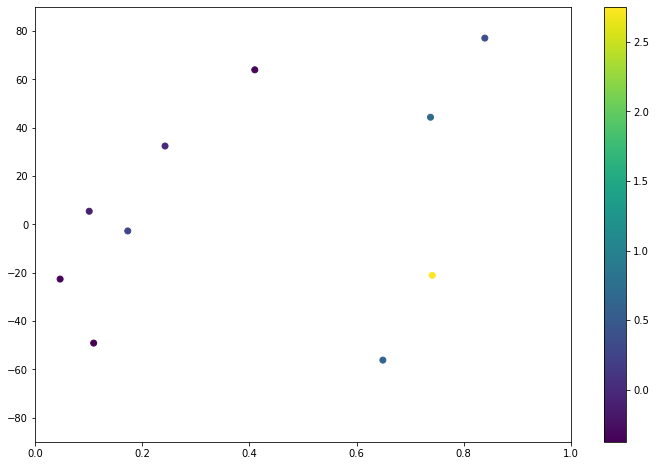

In [407]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.colorbar()

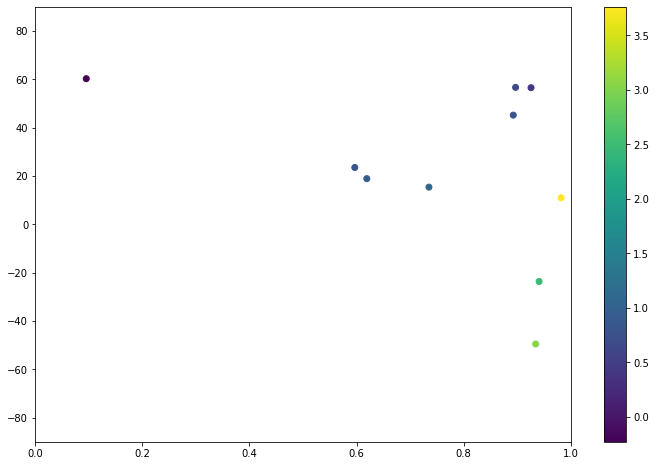

In [396]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.colorbar()

In [560]:
erand = np.loadtxt('31721_e_rand.csv')
wrand = np.loadtxt('31721_w_rand.csv')
efit = np.loadtxt('31721_es_best.csv')
wfit = np.loadtxt('31721_ws_best.csv')

In [564]:
errs = np.abs((erand-efit)/erand)

In [588]:
errs

array([1.09612249e-01, 2.77707188e-01, 3.24760967e-02, 1.19246482e-01,
       4.10805225e-02, 6.42226043e-01, 3.16838922e-01, 2.43508115e-01,
       8.45079589e-01, 5.42086386e-02, 8.18905049e-01, 5.16023868e-03,
       4.51909869e-01, 5.25078762e-03, 4.34700252e-01, 2.38801915e-01,
       2.17174741e-01, 3.28045531e-02, 2.06283349e-01, 1.15919034e-02,
       8.01954973e-02, 1.33675850e-01, 3.14904751e-01, 1.90412000e-01,
       1.03855284e-01, 2.00530000e-01, 3.72341291e-01, 3.23728550e-01,
       5.60525504e-01, 5.17295280e-01, 1.36040711e+00, 6.87338149e+00,
       1.58868334e-01, 2.67233582e-01, 1.01972012e+00, 6.43116204e-01,
       3.74165196e-01, 1.30391148e-01, 8.62654730e+00, 8.67338486e-02,
       2.56962838e-01, 6.05146320e-01, 4.85456990e-01, 4.05607812e-01,
       5.96147313e-01, 2.48175197e-01, 3.42859740e-01, 1.02228314e-01,
       7.12646528e-01, 1.21599143e-01, 9.07150031e-03, 2.11721663e-01,
       4.49101576e-01, 4.15919705e-03, 3.30036747e-01, 4.21436476e-01,
      

Text(0.5, 1.0, 'Color = Percent Error')

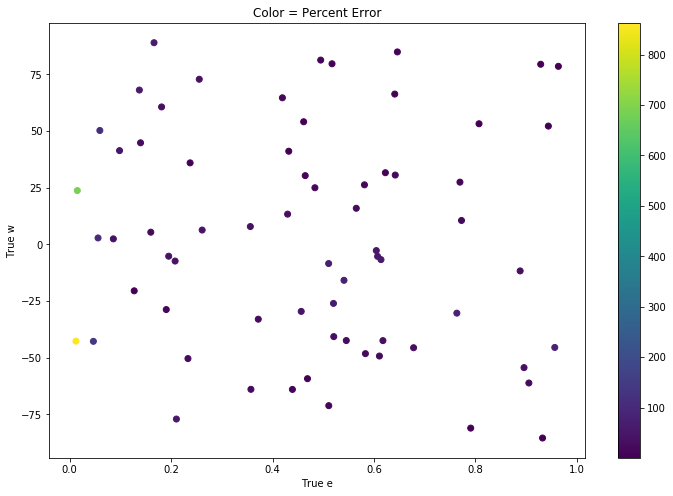

In [580]:
plt.scatter(erand, wrand, c=errs*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('Color = Percent Error')

Text(0.5, 1.0, 'No Outliers ||| Color = Percent Error')

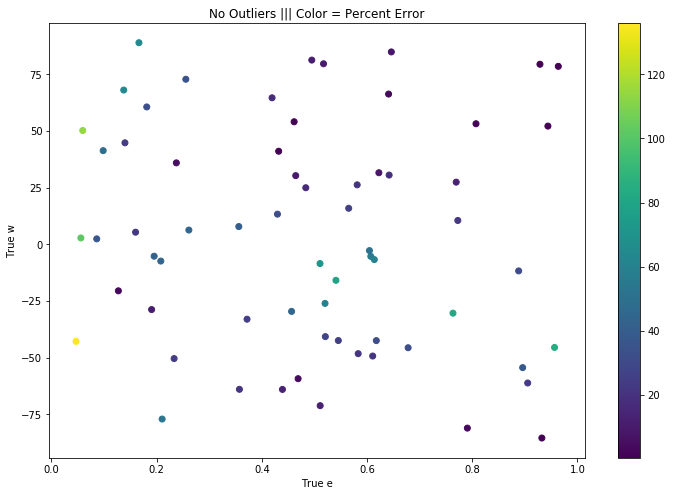

In [593]:
plt.scatter(np.delete(erand, [31, 38]), np.delete(wrand, [31,38]), c=np.delete(errs, [31,38])*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('No Outliers ||| Color = Percent Error')

In [155]:
# es_best_2 = []

# print('Period (Days): ', period)
# print('Rp/Rs: ', rprs)
# print('a/Rs: ', a_rs)
# print('i (deg): ', i)

# for j in range(40):
#     print('e: ', e_rand[j], 'w: ', w_rand[j])
#     ttime = np.linspace(-24, 24, 10000)
#     tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])
#     try:
#         es_best_c = photo_fit(ttime, tflux, tflux_err, rho_star, plot=True, fitter='BFGS')
#         es_best_2.append(es_best_c)
#     except ValueError:
#         es_best_2.append(np.nan)

In [156]:
# errs_2 = np.abs((e_rand[0:40]-es_best)/e_rand[0:40])

In [157]:
# plt.scatter(e_rand[0:40], w_rand[0:40], c=errs_2*100)
# plt.colorbar()
# plt.xlabel('True e')
# plt.ylabel('True w')
# plt.title('Color = Percent Error')